In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay

In [13]:
df = pd.read_csv('S05-hw-dataset.csv')
TARGET = 'default'
y = df[TARGET]
X = df.drop(columns=[TARGET])

<h1>2.3.1<h1>

In [22]:
print(df.shape)
print(df['client_id'].nunique())
print(df.head())
print('_'*140)
print(df.info())
print('_'*140)
print(df.describe())
print('_'*140)
y.value_counts(normalize=True)

(3000, 17)
3000
   client_id  age  income  years_employed  credit_score  debt_to_income  \
0          1   25   94074              22           839        0.547339   
1          2   58   51884              26           565        0.290882   
2          3   53   48656              39           561        0.522340   
3          4   42   81492              30           582        0.709123   
4          5   42   94713               8           642        0.793392   

   num_credit_cards  num_late_payments  has_mortgage  has_car_loan  \
0                 1                  7             0             0   
1                 1                  1             0             1   
2                 1                 13             0             0   
3                 2                 10             1             1   
4                 3                  3             0             0   

   savings_balance  checking_balance  region_risk_score  \
0            26057              5229           0.0800

default
0    0.589667
1    0.410333
Name: proportion, dtype: float64

<h1>2.3.1 (4)<h1>

сколько объектов и признаков в датасете: 3000, 16<br>
есть ли явные аномалии: нет<br>
как распределён таргет: 0-59%; 1-41%

<h1>2.3.3. Train/Test-сплит и бейзлайн-модель<h1>

In [23]:
RANDOM_STATE = 42
X_temp, X_test, y_temp, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_temp
)

In [24]:
print("Размеры выборок:")
print("  train:", X_train.shape)
print("  val:  ", X_val.shape)
print("  test: ", X_test.shape)

print("\nРаспределение классов (train):")
print(y_train.value_counts(normalize=True))

print("\nРаспределение классов (val):")
print(y_val.value_counts(normalize=True))

print("\nРаспределение классов (test):")
print(y_test.value_counts(normalize=True))

Размеры выборок:
  train: (1920, 16)
  val:   (480, 16)
  test:  (600, 16)

Распределение классов (train):
default
0    0.589583
1    0.410417
Name: proportion, dtype: float64

Распределение классов (val):
default
0    0.589583
1    0.410417
Name: proportion, dtype: float64

Распределение классов (test):
default
0    0.59
1    0.41
Name: proportion, dtype: float64


In [29]:
baseline = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)
baseline.fit(X_train, y_train)
y_val_pred_base = baseline.predict(X_val)
y_val_pred_proba_base = baseline.predict_proba(X_val)[:, 1]

In [30]:
print(accuracy_score(y_val, y_val_pred_base), roc_auc_score(y_val, y_val_pred_proba_base))

0.5895833333333333 0.5


базовая модель необходима для точки отсчета. любая построенная модель должна выдавать метрики не хуже базовой модели

<h1>2.3.4. Логистическая регрессия и подбор гиперпараметров<h1>


In [34]:
pipe = (Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=100, random_state=RANDOM_STATE, solver="liblinear", penalty="l2", ))
]))

In [37]:
param_grid = {'lr__C': [0.01, 0.1, 1.0, 10.0, 100.0]}
grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
    verbose=1,
)

In [38]:
grid_search.fit(X_val, y_val)
print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
{'lr__C': 0.1}
0.858971145813251


d:\codes\aie\myAIEProject\homeworks\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


In [40]:
best_model = grid_search.best_estimator_
y_test_pred_best = best_model.predict(X_test)
y_test_proba_best = best_model.predict_proba(X_test)[:, 1]

print(accuracy_score(y_test, y_test_pred_best))
print(roc_auc_score(y_test, y_test_proba_best))

0.8016666666666666
0.8746612466124661


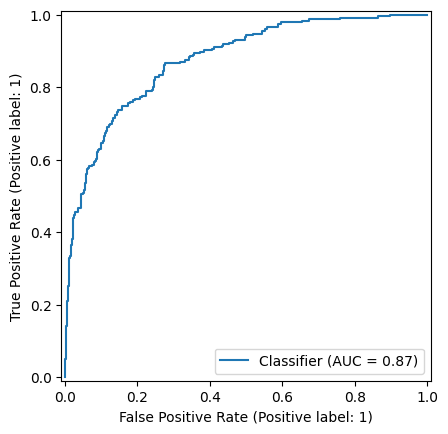

In [43]:
fig = RocCurveDisplay.from_predictions(y_test, y_test_proba_best)
fig.figure_.savefig('figures/ROC.png')
fig

<h1>2.3.5. Сравнение бейзлайна и логистической регрессии, текстовые выводы<h1>

In [47]:
print('baseline модель:')
print(f'accuracy -- {accuracy_score(y_val, y_val_pred_base)}')
print(f'roc -- {roc_auc_score(y_val, y_val_pred_proba_base)}')

print('')
print('best модель:')
print(f'accuracy -- {accuracy_score(y_test, y_test_pred_best)}')
print(f'roc -- {roc_auc_score(y_test, y_test_proba_best)}')

baseline модель:
accuracy -- 0.5895833333333333
roc -- 0.5

best модель:
accuracy -- 0.8016666666666666
roc -- 0.8746612466124661


DummyClassifier либо выдает один и тот же ответ, либо с равной вероятностью выдает результат. те для этой модели признаки не несут никакой вклад<br>
наша модель обучается на признаках и пытается найти весовые коэффиценты<br>

accuracy выросла на 0.21<br>
roc выросла на 0.37<br>

исходя из результатов метрик и факте обучения на признаках, разумнее всего выбрать модель логистической регрессии